In [1]:
import numpy as np
from scipy.optimize import root_scalar
from matplotlib import pyplot as plt

from tqdm import tqdm

from gcv import SketchedSVDRidge, SketchedSolveRidge, EnsembleGCV, SketchedRidgeParams
from gcv.sketches import GaussianSketchFactory, OrthogonalSketchFactory, CountSketchFactory, SubsampledFourierSketchFactory, SketchSizeParams

In [2]:
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}\usepackage{bm}')
plt.rcParams['figure.figsize'] = [6, 2]
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 'small'
plt.rcParams['axes.titlepad'] = 3
plt.rcParams['xtick.labelsize'] = 'x-small'
plt.rcParams['ytick.labelsize'] = plt.rcParams['xtick.labelsize']
plt.rcParams['legend.fontsize'] = 8
plt.rcParams['legend.handlelength'] = 1.5
plt.rcParams['lines.markersize'] = 3
plt.rcParams['lines.linewidth'] = 0.7
plt.rcParams['patch.linewidth'] = 0.7
plt.rcParams['hatch.linewidth'] = 0.7
plt.rcParams['axes.linewidth'] = 0.6
plt.rcParams['grid.linewidth'] = 0.6
plt.rcParams['xtick.major.width'] = 0.6
plt.rcParams['xtick.minor.width'] = 0.4
plt.rcParams['ytick.major.width'] = plt.rcParams['xtick.major.width']
plt.rcParams['ytick.minor.width'] = plt.rcParams['xtick.minor.width']

color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
marker_cycle = ['o', 's', 'v', 'D', 'P', 'X', '*']

In [3]:
def dual_sketch_gcv_path(X, y, factory, q, beta, a, sigma, lamdas):

    R1_gcv = np.zeros(len(lamdas))
    R2_gcv = np.zeros(len(lamdas))

    R1_gen = np.zeros(len(lamdas))
    R2_gen = np.zeros(len(lamdas))

    ridge1 = SketchedSVDRidge(X, y, factory)
    ridge2 = SketchedSVDRidge(X, y, factory)
    ens = EnsembleGCV([ridge1, ridge2])
    ridge1 = EnsembleGCV([ridge1])
    ridge2 = EnsembleGCV([ridge2])

    ridge_nosketch = SketchedSVDRidge(X, y, None)
    ridge_nosketch = EnsembleGCV([ridge_nosketch])

    for i, lamda in enumerate(lamdas):

        params = SketchedRidgeParams(lamda, SketchSizeParams(q))

        R1_gcv[i] = (ridge1.eval_gcv(params) + ridge2.eval_gcv(params)) / 2
        R2_gcv[i] = ens.eval_gcv(params)

        R1_gen[i] = (ridge1.eval_cond_gen(np.diag(a), beta, sigma, params) + ridge2.eval_cond_gen(np.diag(a), beta, sigma, params)) / 2
        R2_gen[i] = ens.eval_cond_gen(np.diag(a), beta, sigma, params)
    
    return R1_gcv, R2_gcv, R1_gen, R2_gen

def eval_gcv_primal(X, y, ens, params, m=None):

    n, p = X.shape
    if m is None:
        m = n

    res = y - ens.predict(X, params)

    gcv = np.linalg.norm(res) ** 2 / n / ens.gcv_correction(params) ** 2

    K = len(ens.regressors)
    res_indivs = [y - ridge.predict(X, params) for ridge in ens.regressors]
    tr_n = ens.div(params) / n
    tr_n_indivs = [ridge.div(params) / n for ridge in ens.regressors]
    n_m_1 = n / m - 1
    gcv_corrected_indivs = [
        np.linalg.norm(res_indiv) ** 2 / n / ((1 - tr_n_indiv) + n_m_1 * tr_n_indiv ** 2)
        for res_indiv, tr_n_indiv in zip(res_indivs, tr_n_indivs)
    ]

    gcv_corrected = gcv - tr_n ** 2 * n_m_1 / K / (1 - tr_n) ** 2 * np.mean(gcv_corrected_indivs)

    return gcv, gcv_corrected

def primal_sketch_gcv_path(X, y, factory, m, beta, a, sigma, lamdas):

    n, p = X.shape

    R1_gcv = np.zeros(len(lamdas))
    R1_gcv_corrected = np.zeros(len(lamdas))
    R2_gcv = np.zeros(len(lamdas))
    R2_gcv_corrected = np.zeros(len(lamdas))

    R1_gen = np.zeros(len(lamdas))
    R2_gen = np.zeros(len(lamdas))

    T1h = factory(SketchSizeParams(m))
    T2h = factory(SketchSizeParams(m))

    T1X = T1h @ X
    T2X = T2h @ X
    T1y = T1h @ y
    T2y = T2h @ y

    ridge1 = SketchedSVDRidge(T1X, T1y, None)
    ridge1.n = n
    ridge2 = SketchedSVDRidge(T2X, T2y, None)
    ridge2.n = n

    ens = EnsembleGCV([ridge1, ridge2])
    ridge1 = EnsembleGCV([ridge1])
    ridge2 = EnsembleGCV([ridge2])

    ridge_nosketch = SketchedSVDRidge(X, y, None)
    ridge_nosketch = EnsembleGCV([ridge_nosketch])

    for i, lamda in enumerate(lamdas):

        params = SketchedRidgeParams(lamda, SketchSizeParams(p))

        gcv1, gcv1_corrected = eval_gcv_primal(X, y, ridge1, params, m)
        gcv2, gcv2_corrected = eval_gcv_primal(X, y, ridge2, params, m)

        R1_gcv[i] = (gcv1 + gcv2) / 2
        R1_gcv_corrected[i] = (gcv1_corrected + gcv2_corrected) / 2
        R2_gcv[i], R2_gcv_corrected[i] = eval_gcv_primal(X, y, ens, params, m)

        R1_gen[i] = (ridge1.eval_cond_gen(np.diag(a), beta, sigma, params) + ridge2.eval_cond_gen(np.diag(a), beta, sigma, params)) / 2
        R2_gen[i] = ens.eval_cond_gen(np.diag(a), beta, sigma, params)
    
    return R1_gcv, R1_gcv_corrected, R2_gcv, R2_gcv_corrected, R1_gen, R2_gen

def ortho_equiv_mu(sketched_evs, alpha, lamda):

    if lamda == 0:
        m = np.mean(1 / sketched_evs)
        return (1 - alpha) / m

    if lamda < -np.min(sketched_evs[sketched_evs > 0]):
        return np.nan

    S = lambda w: alpha * (1 + w) / (alpha + w)

    return lamda * S(-alpha * np.mean(sketched_evs / (sketched_evs + lamda)))

def gen_data(n, p, a, sigma, rng=None):

    if rng is None:
        rng = np.random.default_rng()

    X = rng.normal(size=(n, p)) * np.sqrt(a)[None, :]
    beta = np.zeros(p)
    p0 = p // 10
    beta[:p0] = rng.normal(size=p0) / np.sqrt(p0)
    y = X @ beta + rng.normal(scale=sigma, size=n)

    return X, beta, y

In [21]:
n, p = 600, 800
q = 100
sigma = 2
rng = np.random.default_rng(0)
n_trials = 50

a = 2 / (1 + 30 * np.linspace(0, 1, p))

# lamdas = np.logspace(-2, 2, 20)
lamdas_base = np.concatenate([np.linspace(-0.5, 1, 300)[:-1], np.logspace(0, 2, 300)])

sketch_names = ['SRDCT']
sketch_factories = [SubsampledFourierSketchFactory(p, transform='dct', rng=rng)]
sketch_factories_primal = [SubsampledFourierSketchFactory(n, transform='dct', rng=rng)]

mu_equiv_dual = np.zeros((len(sketch_names), len(lamdas_base)))
mu_equiv_primal = np.zeros((len(sketch_names), len(lamdas_base)))

# precompute lamda mu mapping
for j, (factory, factory_primal) in enumerate(zip(sketch_factories, sketch_factories_primal)):

    X, _, _ = gen_data(n, p, a, sigma, rng=rng)

    Sh = factory(SketchSizeParams(q))
    XS = (Sh @ X.T).conj().T
    evs = np.linalg.eigvalsh(XS.conj().T @ XS / n)
    mu_equiv_dual[j, :] = [ortho_equiv_mu(evs, q / p, lamda) for lamda in lamdas_base]

    Th = factory_primal(SketchSizeParams(q))
    TX = Th @ X
    evs = np.linalg.eigvalsh(TX @ TX.conj().T / n)
    mu_equiv_primal[j, :] = [ortho_equiv_mu(evs, q / n, lamda) for lamda in lamdas_base]

mu_min = max(np.min(mu_equiv_dual[np.logical_not(np.isnan(mu_equiv_dual))]), np.min(mu_equiv_primal[np.logical_not(np.isnan(mu_equiv_primal))]))
mus = np.logspace(np.log10(mu_min), 2, 50)

lamdas_dual = np.zeros((len(sketch_names), len(mus)))
lamdas_primal = np.zeros((len(sketch_names), len(mus)))
for j in range(len(sketch_names)):
    lamda_interp = lambda mus_new, mus_old: np.interp(mus_new, mus_old[np.logical_not(np.isnan(mus_old))], lamdas_base[np.logical_not(np.isnan(mus_old))])
    lamdas_dual[j, :] = lamda_interp(mus, mu_equiv_dual[j, :])
    lamdas_primal[j, :] = lamda_interp(mus, mu_equiv_primal[j, :])

R_gcv = np.zeros((n_trials, len(mus)))
R_gen = np.zeros((n_trials, len(mus)))

R1_dual_gcv = np.zeros((n_trials, len(sketch_names), len(mus)))
R2_dual_gcv = np.zeros((n_trials, len(sketch_names), len(mus)))
R1_dual_gen = np.zeros((n_trials, len(sketch_names), len(mus)))
R2_dual_gen = np.zeros((n_trials, len(sketch_names), len(mus)))

R1_primal_gcv = np.zeros((n_trials, len(sketch_names), len(mus)))
R1_primal_gcv_corrected = np.zeros((n_trials, len(sketch_names), len(mus)))
R2_primal_gcv = np.zeros((n_trials, len(sketch_names), len(mus)))
R2_primal_gcv_corrected = np.zeros((n_trials, len(sketch_names), len(mus)))
R1_primal_gen = np.zeros((n_trials, len(sketch_names), len(mus)))
R2_primal_gen = np.zeros((n_trials, len(sketch_names), len(mus)))

for t in tqdm(range(n_trials)):

    X, beta, y = gen_data(n, p, a, sigma, rng=rng)

    for j, (factory, factory_primal) in enumerate(zip(sketch_factories, sketch_factories_primal)):

        R1_dual_gcv[t, j, :], R2_dual_gcv[t, j, :], R1_dual_gen[t, j, :], R2_dual_gen[t, j, :] = dual_sketch_gcv_path(X, y, factory, q, beta, a, sigma, lamdas_dual[j, :])
        R1_primal_gcv[t, j, :], R1_primal_gcv_corrected[t, j, :], R2_primal_gcv[t, j, :], R2_primal_gcv_corrected[t, j, :], R1_primal_gen[t, j, :], R2_primal_gen[t, j, :] = primal_sketch_gcv_path(X, y, factory_primal, q, beta, a, sigma, lamdas_primal[j, :])

        if j == 0:

            ridge_nosketch = SketchedSolveRidge(X, y, None)
            ridge_nosketch = EnsembleGCV([ridge_nosketch])

            ridge_nosketch_params_path = [SketchedRidgeParams(mu, SketchSizeParams(p)) for mu in mus]
            R_gcv[t, :] = ridge_nosketch.eval_gcv_path(ridge_nosketch_params_path)
            R_gen[t, :] = ridge_nosketch.eval_cond_gen_path(np.diag(a), beta, sigma, ridge_nosketch_params_path)

100%|██████████| 50/50 [01:44<00:00,  2.08s/it]


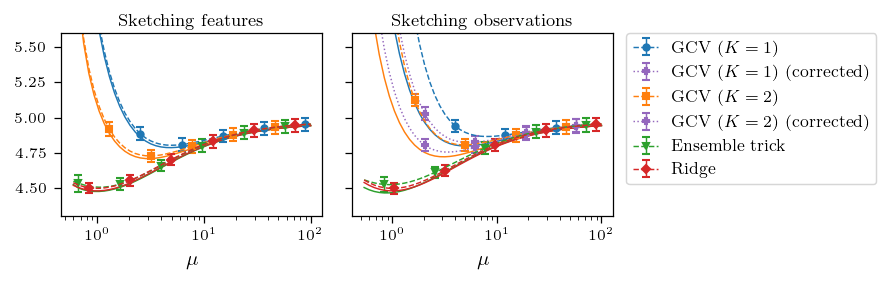

In [27]:
ens_trick_dual_gcv = 2 * R2_dual_gcv - R1_dual_gcv
ens_trick_dual_gen = 2 * R2_dual_gen - R1_dual_gen
ens_trick_primal_gcv = 2 * R2_primal_gcv - R1_primal_gcv
ens_trick_primal_gen = 2 * R2_primal_gen - R1_primal_gen

series = [
    ('GCV ($K=1$)', R1_dual_gcv[:, 0, :], R1_dual_gen[:, 0, :]),
    ('GCV ($K=2$)', R2_dual_gcv[:, 0, :], R2_dual_gen[:, 0, :]),
    ('Ensemble trick', ens_trick_dual_gcv[:, 0, :], ens_trick_dual_gen[:, 0, :]),
    ('Ridge', R_gcv, R_gen),
]

series_primal = [
    ('GCV ($K=1$)', R1_primal_gcv[:, 0, :], R1_primal_gen[:, 0, :]),
    ('GCV ($K=2$)', R2_primal_gcv[:, 0, :], R2_primal_gen[:, 0, :]),
    ('Ensemble trick', ens_trick_primal_gcv[:, 0, :], ens_trick_primal_gen[:, 0, :]),
    ('Ridge', R_gcv, R_gen),
]

mus_dual = mus.copy()
mus_dual[mus_dual < 0.55] = np.nan
mus_primal = mus.copy()
mus_primal[mus_primal < 0.5] = np.nan

capsize = 2

fig, axes = plt.subplots(1, 2, sharey=True)

ax = axes[0]

for i, (label, d_gcv, d_gen) in enumerate(series):
    markevery = (2 * i, 2 * (len(series)))
    ax.plot(mus_dual, np.mean(d_gen, axis=0), color=color_cycle[i])
    ax.errorbar(mus_dual, np.mean(d_gcv, axis=0), yerr=np.std(d_gcv, axis=0) / np.sqrt(n_trials), color=color_cycle[i], linestyle='--', capsize=capsize, errorevery=markevery, markevery=markevery, marker=marker_cycle[i], label=label)

# ax.legend()
ax.set_xscale('log')
ax.set_title('Sketching features')
ax.set_xlabel(r'$\mu$')

ax = axes[1]

for i, (label, d_gcv, d_gen) in enumerate(series_primal):
    markevery = (2 * (i + (1 if i >= 2 else 0)), 2 * (len(series) + 1))
    ax.plot(mus_primal, np.mean(d_gen, axis=0), color=color_cycle[i])
    ax.errorbar(mus_primal, np.mean(d_gcv, axis=0), yerr=np.std(d_gcv, axis=0) / np.sqrt(n_trials), color=color_cycle[i], linestyle='--', marker=marker_cycle[i], capsize=capsize, errorevery=markevery, markevery=markevery, label=label)
    if label == 'GCV ($K=1$)':
        markevery = (2 * 2, 2 * (len(series) + 1))
        d_gcv_corrected = R1_primal_gcv_corrected[:, 0, :]
        ax.errorbar(mus_primal, np.mean(d_gcv_corrected, axis=0), yerr=np.std(d_gcv_corrected, axis=0) / np.sqrt(n_trials), color=color_cycle[len(series)], linestyle=':', marker=marker_cycle[len(series)], capsize=capsize, errorevery=markevery, markevery=markevery, label=label + ' (corrected)')
    if label == 'GCV ($K=2$)':
        markevery = (2 * 2, 2 * (len(series) + 1))
        d_gcv_corrected = R2_primal_gcv_corrected[:, 0, :]
        ax.errorbar(mus_primal, np.mean(d_gcv_corrected, axis=0), yerr=np.std(d_gcv_corrected, axis=0) / np.sqrt(n_trials), color=color_cycle[len(series)], linestyle=':', marker=marker_cycle[len(series)], capsize=capsize, errorevery=markevery, markevery=markevery, label=label + ' (corrected)')

ax.set_ylim(4.3, 5.6)
ax.set_title('Sketching observations')
ax.set_xlabel(r'$\mu$')

#place legend off to right
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

ax.set_xscale('log')

plt.tight_layout()
plt.show()

In [6]:
n = 600
p = 800
a = 2 / (1 + 30 * np.linspace(0, 1, p))
sigma = 2
rng = np.random.default_rng(42)

qs = np.unique(np.logspace(0, np.log10(p), 20).astype(int))
n_trials = 50
n_ens = 10

X, _, _ = gen_data(n, p, a, sigma, rng=rng)

factory = SubsampledFourierSketchFactory(p, transform='dct', rng=rng)
Sh = factory(SketchSizeParams(p))
XS = (Sh @ X.T).conj().T

mus_q = np.zeros(len(qs))
for j, q in enumerate(tqdm(qs)):
    Z = XS[:, :q] * np.sqrt(p / q)
    mus_q[j] = ortho_equiv_mu(np.linalg.eigvalsh(Z.conj().T @ Z / n), q / p, 0)

R1_alpha_gcv = np.zeros((n_trials, len(qs)))
R2_alpha_gcv = np.zeros((n_trials, len(qs)))
RK_alpha_gcv = np.zeros((n_trials, len(qs)))
R1_alpha_gen = np.zeros((n_trials, len(qs)))
R2_alpha_gen = np.zeros((n_trials, len(qs)))
RK_alpha_gen = np.zeros((n_trials, len(qs)))

R_ridge_gcv = np.zeros((n_trials, len(qs)))
R_ridge_gen = np.zeros((n_trials, len(qs)))

for t in tqdm(range(n_trials)):

    X, beta, y = gen_data(n, p, a, sigma, rng=rng)

    Shs = []
    XSs = []

    for k in range(n_ens):
        Sh = factory(SketchSizeParams(p))
        Shs.append(Sh.todense())
        XSs.append((Sh @ X.T).conj().T)

    for j, q in enumerate(qs):

        ridges = [EnsembleGCV([SketchedSolveRidge(XS[:, :q] * np.sqrt(p / q), y, None)]) for XS in XSs]
        params = SketchedRidgeParams(0, SketchSizeParams(q))

        y_hats = [ridge.y_hat(params) for ridge in ridges]
        y_hat_2 = np.mean(y_hats[:2], axis=0)
        y_hat_K = np.mean(y_hats, axis=0)

        gcv_corrections = np.array([ridge.gcv_correction(params) for ridge in ridges])
        gcv_correction_2 = np.mean(gcv_corrections[:2])
        gcv_correction_K = np.mean(gcv_corrections)

        R1_alpha_gcv[t, j] = np.mean([ridge.eval_gcv(params) for ridge in ridges[:2]])
        R2_alpha_gcv[t, j] = np.linalg.norm(y - y_hat_2) ** 2 / n / gcv_correction_2 ** 2
        RK_alpha_gcv[t, j] = np.linalg.norm(y - y_hat_K) ** 2 / n / gcv_correction_K ** 2

        beta_hats = []
        for ridge, Sh in zip(ridges, Shs):
            beta_hats.append((Sh.conj().T[:, :q] * np.sqrt(p / q)) @ ridge.beta(params))
        
        beta_errs = [beta - beta_hat for beta_hat in beta_hats]
        beta_err_2 = np.mean(beta_errs[:2], axis=0)
        beta_err_K = np.mean(beta_errs, axis=0)

        R1_alpha_gen[t, j] = np.mean([err @ (a * err) + sigma ** 2 for err in beta_errs[:2]])
        R2_alpha_gen[t, j] = beta_err_2 @ (a * beta_err_2) + sigma ** 2
        RK_alpha_gen[t, j] = beta_err_K @ (a * beta_err_K) + sigma ** 2

    ridge_nosketch = SketchedSolveRidge(X, y, None)
    ridge_nosketch = EnsembleGCV([ridge_nosketch])

    ridge_nosketch_params_path = [SketchedRidgeParams(mu, SketchSizeParams(p)) for mu in mus_q]
    R_ridge_gcv[t, :] = ridge_nosketch.eval_gcv_path(ridge_nosketch_params_path)
    R_ridge_gen[t, :] = ridge_nosketch.eval_cond_gen_path(np.diag(a), beta, sigma, ridge_nosketch_params_path)



100%|██████████| 50/50 [02:03<00:00,  2.47s/it]


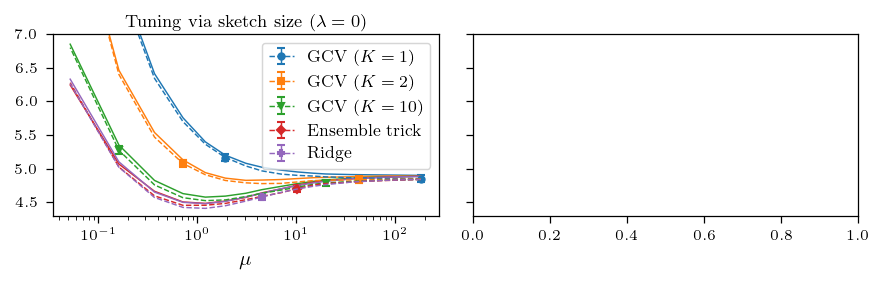

In [7]:
ens_trick_alpha_gcv = 2 * R2_alpha_gcv - R1_alpha_gcv
ens_trick_alpha_gen = 2 * R2_alpha_gen - R1_alpha_gen

series = [
    ('GCV ($K=1$)', R1_alpha_gcv, R1_alpha_gen),
    ('GCV ($K=2$)', R2_alpha_gcv, R2_alpha_gen),
    (f'GCV ($K={n_ens}$)', RK_alpha_gcv, RK_alpha_gen),
    ('Ensemble trick', ens_trick_alpha_gcv, ens_trick_alpha_gen),
    ('Ridge', R_ridge_gcv, R_ridge_gen),
]

mus_plot = mus_q.copy()
mus_plot[mus_plot < 0.01] = np.nan

fig, axes = plt.subplots(1, 2, sharey=True)

ax = axes[0]

for i, (label, d_gcv, d_gen) in enumerate(series):
    markevery = (2 * i, 2 * (len(series)))
    ax.plot(mus_plot, np.mean(d_gen, axis=0), color=color_cycle[i])
    ax.errorbar(mus_plot, np.mean(d_gcv, axis=0), yerr=np.std(d_gcv, axis=0) / np.sqrt(n_trials), color=color_cycle[i], linestyle='--', capsize=capsize, errorevery=markevery, markevery=markevery, marker=marker_cycle[i], label=label)

ax.set_xscale('log')
ax.legend()
ax.set_ylim(4.3, 7)
ax.set_title('Tuning via sketch size ($\lambda = 0$)')
ax.set_xlabel(r'$\mu$')

plt.tight_layout()
plt.show()

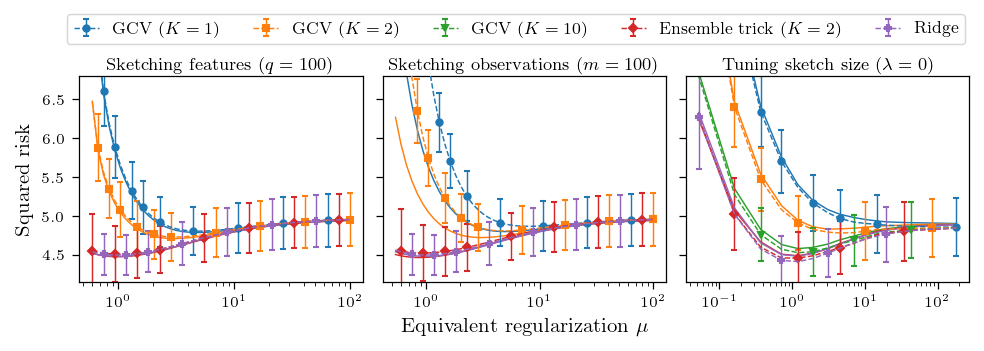

In [41]:
series = [                                                                      # manually select errorbar locations for better spacing
    ('GCV ($K=1$)', R1_dual_gcv[:, 0, :], R1_dual_gen[:, 0, :], color_cycle[0], [3, 5, 7, 10, 12, 15, 21, 29, 37, 45]),
    ('GCV ($K=2$)', R2_dual_gcv[:, 0, :], R2_dual_gen[:, 0, :], color_cycle[1], [4, 6, 8, 11, 14, 17, 25, 33, 41, 49]),
    ('Ensemble trick', ens_trick_dual_gcv[:, 0, :], ens_trick_dual_gen[:, 0, :], color_cycle[3], [3, 7, 11, 15, 23, 31, 39, 47]),
    ('Ridge', R_gcv, R_gen, color_cycle[4], [5, 9, 13, 19, 27, 35, 43]),
]

series_primal = [
    ('GCV ($K=1$)', R1_primal_gcv[:, 0, :], R1_primal_gen[:, 0, :], color_cycle[0], [6, 7, 10, 12, 15, 21, 29, 37, 45]),
    ('GCV ($K=2$)', R2_primal_gcv[:, 0, :], R2_primal_gen[:, 0, :], color_cycle[1], [6, 8, 11, 14, 17, 25, 33, 41, 49]),
    ('Ensemble trick', ens_trick_primal_gcv[:, 0, :], ens_trick_primal_gen[:, 0, :], color_cycle[3], [3, 7, 11, 15, 23, 31, 39, 47]),
    ('Ridge', R_gcv, R_gen, color_cycle[4], [5, 9, 13, 19, 27, 35, 43]),
]


capsize = 1.5

fig, axes = plt.subplots(1, 3, figsize=(6.5, 2), sharey=True)

ax = axes[0]

for i, (label, d_gcv, d_gen, color, markevery) in enumerate(series):
    if i > 1:
        i += 1
    ax.plot(mus_dual, np.mean(d_gen, axis=0), color=color)
    ax.errorbar(mus_dual, np.mean(d_gcv, axis=0), yerr=np.std(d_gcv, axis=0), color=color, linestyle='--', capsize=capsize, errorevery=markevery, markevery=markevery, marker=marker_cycle[i], label=label)

# ax.legend()
ax.set_xscale('log')
ax.set_ylabel('Squared risk')
ax.set_title('Sketching features ($q = 100$)')


ax = axes[1]

for i, (label, d_gcv, d_gen, color, markevery) in enumerate(series_primal):
    if i > 1:
        i += 1
    ax.plot(mus_primal, np.mean(d_gen, axis=0), color=color)
    ax.errorbar(mus_primal, np.mean(d_gcv, axis=0), yerr=np.std(d_gcv, axis=0), color=color, linestyle='--', marker=marker_cycle[i], capsize=capsize, errorevery=markevery, markevery=markevery, zorder=20)
    # if label == 'GCV ($K=1$)':
    #     markevery = 2
    #     d_gcv_corrected = R1_primal_gcv_corrected[:, 0, :]
    #     gcv_correction_artist, = ax.plot(mus_primal, np.mean(d_gcv_corrected, axis=0), color=color_cycle[0], linestyle=':', marker='x', markevery=markevery, label='$K=1$, corrected', zorder=10)
    # if label == 'GCV ($K=2$)':
    #     markevery = 2
    #     d_gcv_corrected = R2_primal_gcv_corrected[:, 0, :]
    #     gcv_correction_artist, = ax.plot(mus_primal, np.mean(d_gcv_corrected, axis=0), color=color_cycle[1], linestyle=':', marker='x', markevery=markevery, label='$K=2$, corrected', zorder=10)

ax.set_ylim(4.3, 5.6)
# ax.legend()
ax.set_title('Sketching observations ($m = 100$)')
ax.set_xlabel(r'Equivalent regularization $\mu$')
ax.set_xscale('log')

series = [
    ('GCV ($K=1$)', R1_alpha_gcv, R1_alpha_gen, [0, 5, 8, 10, 12, 13, 14, 16]),
    ('GCV ($K=2$)', R2_alpha_gcv, R2_alpha_gen, [1, 6, 11, 13, 14, 15, 16]),
    (f'GCV ($K={n_ens}$)', RK_alpha_gcv, RK_alpha_gen, [2, 7, 10, 13]),
    ('Ensemble trick ($K=2$)', ens_trick_alpha_gcv, ens_trick_alpha_gen, [3, 8, 11, 14]),
    ('Ridge', R_ridge_gcv, R_ridge_gen, [4, 9, 12, 15]),
]

ax = axes[2]
artists = []

for i, (label, d_gcv, d_gen, markevery) in enumerate(series):
    # markevery = (i, (len(series)))
    # markevery = []
    ax.plot(mus_plot, np.mean(d_gen, axis=0), color=color_cycle[i])
    artist = ax.errorbar(mus_plot, np.mean(d_gcv, axis=0), yerr=np.std(d_gcv, axis=0), color=color_cycle[i], linestyle='--', capsize=capsize, errorevery=markevery, markevery=markevery, marker=marker_cycle[i], label=label)
    artists.append(artist)

ax.set_xscale('log')
ax.set_ylim(4.15, 6.8)
ax.set_title('Tuning sketch size ($\lambda = 0$)')

ax.set_xscale('log')

plt.tight_layout(pad=0.5)

# place legend on top
ax.legend(handles=artists, labels=[artist.get_label() for artist in artists], bbox_to_anchor=(-0.6, 1.3), loc='upper center', borderaxespad=0., ncol=5)

plt.savefig('figures/ensemble_trick.pdf', bbox_inches='tight')

plt.show()